In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 04

## Percentiles 

Suppose we wanted to manually compute the 55th percentile of the following array:

In [47]:
x = make_array(43, 20, 51, 7, 28)

**Step 1.** To compute percentiles we first sort the data

In [48]:
sorted_x = np.sort(x)
sorted_x

array([ 7, 20, 28, 43, 51])

In [49]:
ptbl = Table().with_columns(
    "Percentile", 100 * (np.arange(0, len(x)) + 1) / len(x),
    "Element", sorted_x)
ptbl

Percentile,Element
20,7
40,20
60,28
80,43
100,51


**Step 2.** Figure out where the $p^\text{th}$ percentile would be.

e.g. p = 55

In [5]:
55 / 100 * 6

3.3000000000000003

In [6]:
p = 55
ind = int(np.ceil(len(x) * p/100) - 1)
ind

3

In [7]:
sorted_x.item(ind)

34

The above calculation is confusing and brittle (try p=0).  Instead, we should use the `percentile` function.

### Using the Percentile Function

In [8]:
percentile?

Signature: percentile(p, arr=None)
Docstring:
Returns the pth percentile of the input array (the value that is at
least as great as p% of the values in the array).

If arr is not provided, percentile returns itself curried with p

>>> percentile(74.9, [1, 3, 5, 9])
5
>>> percentile(75, [1, 3, 5, 9])
5
>>> percentile(75.1, [1, 3, 5, 9])
9
>>> f = percentile(75)
>>> f([1, 3, 5, 9])
5
File:      ~/.virtualenvs/cs5/lib/python3.10/site-packages/datascience/util.py
Type:      function

Recall the precentile table. 

In [9]:
ptbl

Percentile,Element
16.6667,7
33.3333,20
50,28
66.6667,34
83.3333,43
100,51


Let's try a few values.

In [10]:
percentile(50, x)

28

In [11]:
percentile(55, x)

34

In [12]:
percentile(0, x)

7

In [13]:
percentile(100, x)

51

---
<center> Return to Slides </center>

---

## Discussion Question

In [14]:
s = make_array(1, 3, 5, 7, 9)

In [15]:
Table().with_columns(
    "Percentile", 100*(np.arange(0, len(s))+1)/len(s),
    "Element", sorted(s))

Percentile,Element
20,1
40,3
60,5
80,7
100,9


In [16]:
percentile(10, s) == 0

False

In [17]:
percentile(39, s) == percentile(40, s)

True

In [18]:
percentile(40, s) == percentile(41, s)

False

In [19]:
percentile(50, s) == 5

True

---
<center> Return to Slides </center>

---

## Inference: Estimation

To demonstrate the process of estimating a parameter, let's examine the 2019 San Francisco public records.  We obtained this data from the [SF Open Data Portal](https://datasf.org/opendata/).  For the purposes of this exercise, we will assume that this a census of the compensation data: that it contains the compensation for a public workers.  

In [20]:
sf = Table.read_table('data/san_francisco_2019.csv')
sf.show(3)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


Suppose we are interested in studying `"Total Compensation"`.  Let's make a histogram of the total compensation.

/home/griessbaum/.virtualenvs/cs5/lib/python3.10/site-packages/datascience/tables.py:5865: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


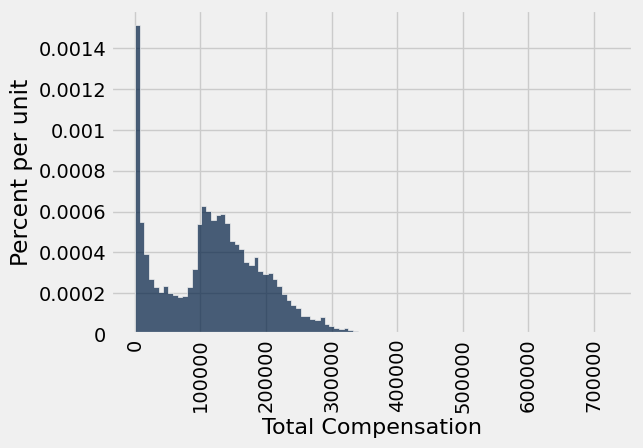

In [21]:
sf.hist("Total Compensation", bins=100)

Who is getting paid the most?

In [22]:
# Who made the most money
sf.sort('Total Compensation', descending=True).show(5)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Retirement Services,Administrative & Mgmt (Unrep),Chief Investment Officer,577633,0,146398,724031
General Administration & Finance,Retirement Services,Unassigned,Managing Director,483072,0,134879,617951
General Administration & Finance,Retirement Services,Unassigned,Managing Director,482649,0,134905,617554
General Administration & Finance,Retirement Services,Unassigned,Managing Director,451507,0,120276,571784
General Administration & Finance,Retirement Services,Unassigned,Managing Director,449378,0,120857,570235


Who is getting paid the least?

In [23]:
sf.sort('Total Compensation').show(10)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer,0,0,0,0
Public Protection,Fire Department,"Clerical, Secretarial & Steno",Senior Clerk Typist,0,0,0,0
Public Protection,Juvenile Court,Correction & Detention,"Counselor, Juvenile Hall PERS",0,0,0,0
Public Protection,Police,"Clerical, Secretarial & Steno",Clerk Typist,0,0,0,0
Public Protection,Sheriff,Correction & Detention,Deputy Sheriff,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Sub-Professional Engineering,StdntDsgn Train2/Arch/Eng/Plng,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,"Clerical, Secretarial & Steno",Executive Secretary 1,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,"Payroll, Billing & Accounting",Senior Account Clerk,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,0,0,0,0


There is a clear spike around **zero**!  Why?

We will focus on those that worked at least 20 hours at minimum wage for an entire year. 

In [24]:
min_salary = 15 * 20 * 50 # $15/hr, 20 hr/wk, 50 weeks
print("Min Salary", min_salary)
sf = sf.where('Salary', are.above(min_salary))

Min Salary 15000


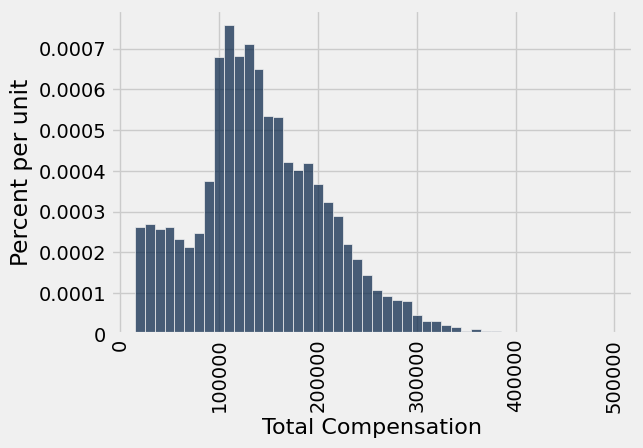

In [25]:
salary_bins = np.arange(min_salary, 500000, 10000)
sf.hist("Total Compensation", bins=salary_bins)

### The Population Parameter

Here we have access to the population so we can compute parameters directly.  

For example, suppose we were interested in the median compensation.  Then we could compute it directly on our data:

In [26]:
pop_median = percentile(50, sf.column("Total Compensation"))
pop_median

135747.0

In most real-world settings, you won't have access to the population.  Instead, you will take a random sample. 

Suppose we sample 400 people from our population.

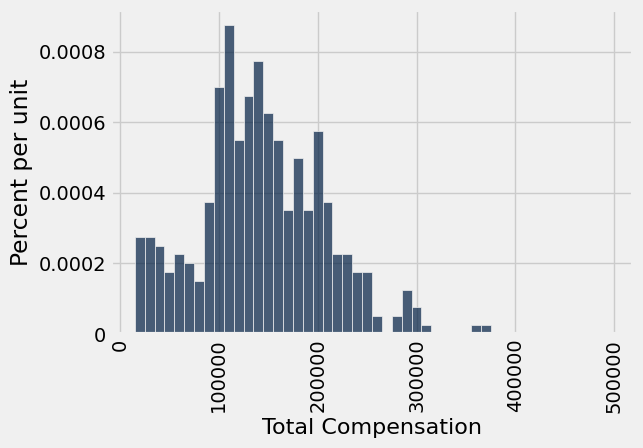

In [27]:
# An Empirical Distribution
our_sample = sf.sample(400, with_replacement=False)
our_sample.hist('Total Compensation', bins=salary_bins)

We can use the sample median (statistic) as an estimate of the parameter value.

In [28]:
# Estimate: Median of a Sample
percentile(50, our_sample.column('Total Compensation'))

138801.0

But in the real world we won't be able to keep going back to the population. How do we generate a new random sample *without going back to the population?*

---
<center> Return to Slides </center>

---

## Variability of the Estimate

If we could get additional samples from the population, how much variability would their be in our estimate of the median?

In [29]:
def generate_sample_median(samp_size):
    new_sample = sf.sample(samp_size, with_replacement=False)
    return percentile(50, new_sample.column('Total Compensation'))

In [30]:
generate_sample_median(400)

132513.0

## Quantifying Uncertainty

Because we have access to the population, we can simulate many samples from the population:

In [31]:
sample_medians = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(400)
    sample_medians = np.append(sample_medians, new_median)

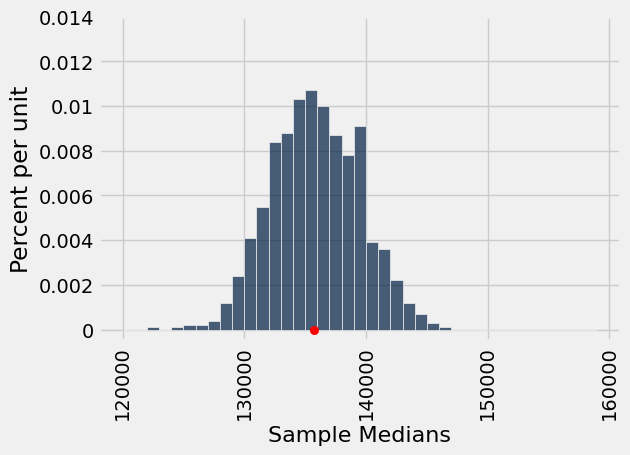

In [32]:
med_bins = np.arange(120000, 160000, 1000)
Table().with_column('Sample Medians', sample_medians).hist(bins=med_bins)

plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

What happens if we do the same thing again with slightly larger samples?

In [33]:
sample_medians2 = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(800)
    sample_medians2 = np.append(sample_medians2, new_median)

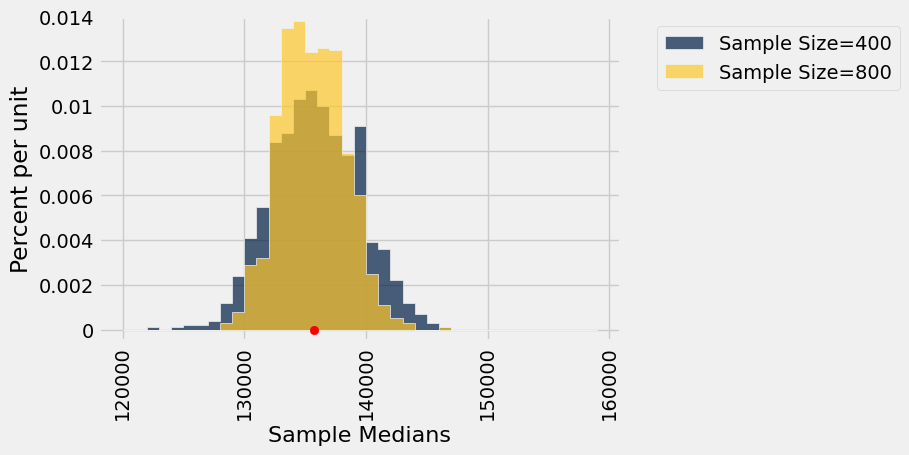

In [34]:
(Table()
     .with_columns("Sample Medians", sample_medians,
                   "Sample Size", 400)
     .append(Table().with_columns("Sample Medians", sample_medians2,
                                  "Sample Size", 800))
     .hist("Sample Medians", group="Sample Size", bins=med_bins)
)
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

But in the real world we won't be able to keep going back to the population. How do we generate a new random sample *without going back to the population?*

---
<center> Return to Slides </center>

---

# Bootstrap

Sample randomly
 - from the original sample
 - with replacement
 - the same number of times as the original sample size


**Step 1:** Sample the original sample **With Replacement** the same number of times as the original sample size.

```python
table.sample() # All you need!
```

The default behavior of tbl.sample:
1. at random with replacement,
2. the same number of times as rows of tbl

In [35]:
bootstrap_sample = our_sample.sample()
print("Number of Rows:", bootstrap_sample.num_rows)

Number of Rows: 400


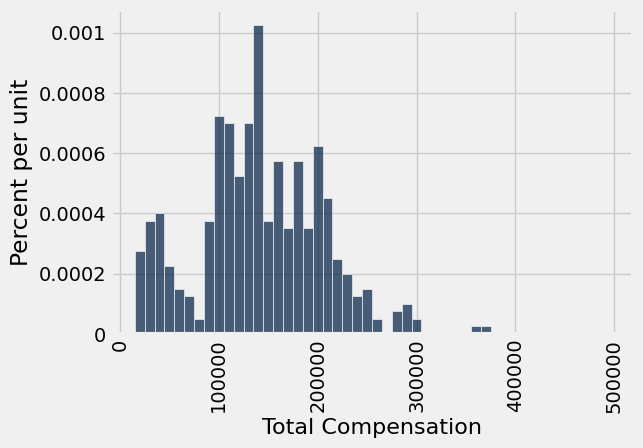

In [36]:
bootstrap_sample.hist('Total Compensation', bins=salary_bins)

**Step 2:** Compute statistic on bootstrap sample.

In [37]:
percentile(50, bootstrap_sample.column('Total Compensation'))

138936.0

**Repeat** the sampling process many times:

In [38]:
def one_bootstrap_median():
    # draw the bootstrap sample
    bootstrap_sample = our_sample.sample()
    # return the median total compensation in the bootstrap sample
    return percentile(50, bootstrap_sample.column('Total Compensation'))

In [39]:
one_bootstrap_median()

138173.0

In [40]:
# Generate the medians of 1000 bootstrap samples
num_repetitions = 1000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

Examine the empirical distribution of the samples.

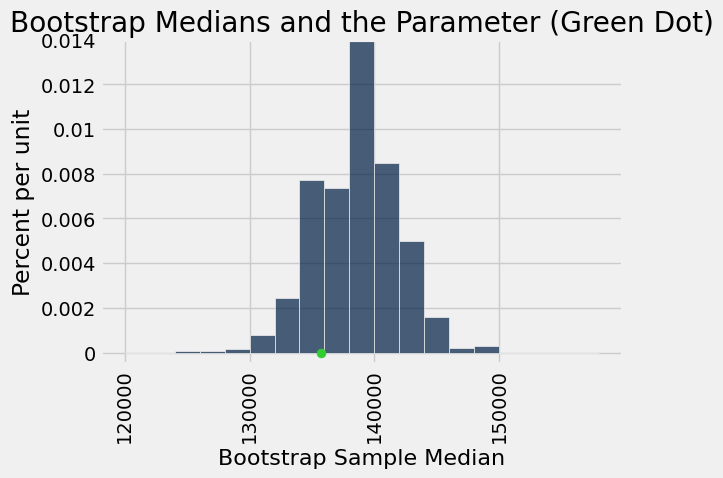

In [41]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(120000, 160000, 2000)
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

### A General Bootstrap Function

The following function implements the general bootstrap procedure.


In [42]:
def bootstrapper(sample, statistic, num_repetitions):
    """
    Returns the statistic computed on a num_repetitions  
    bootstrap samples from sample.
    """
    bstrap_stats = make_array()
    for i in np.arange(num_repetitions):
        # Step 1: Sample the Sample
        bootstrap_sample = sample.sample()
        # Step 2: compute statistics on the sample of the sample
        bootstrap_stat = statistic(bootstrap_sample)
        # Accumulate the statistics
        bstrap_stats = np.append(bstrap_stats, bootstrap_stat)

    return bstrap_stats    

In [43]:
og_sample = sf.sample(400, with_replacement=False)

def compute_median(sample):
    return percentile(50, sample.column("Total Compensation"))

bootstrap_medians = bootstrapper(og_sample, compute_median, 1000)

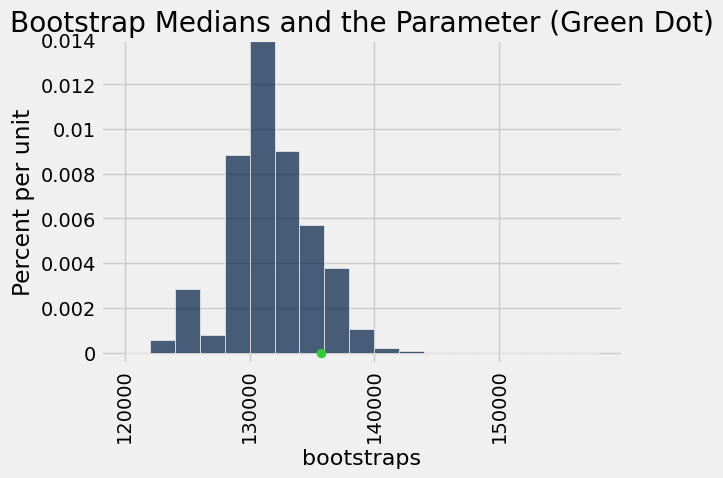

In [44]:
Table().with_column("bootstraps", bootstrap_medians).hist(bins=median_bins)

## Extra Viz code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

---
<center> Return to Slides </center>

---

## Percentile Method: Middle 95% of the Bootstrap Estimates 

Computing confidence intervals is as simple as computing percentiles on the bootstrap samples.  No magic equations!

In [45]:
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right)

array([ 132065.,  144840.])

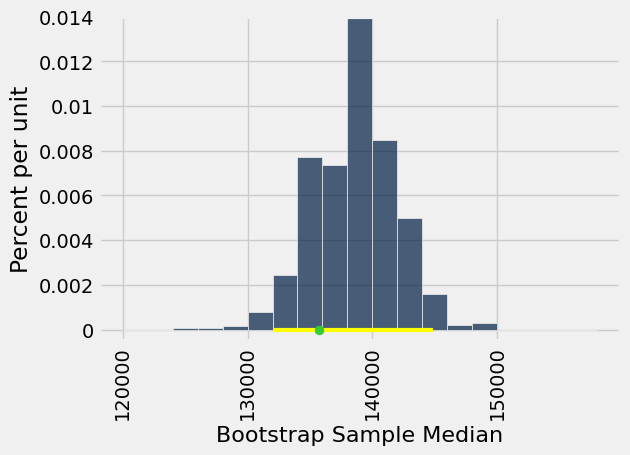

In [46]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);